# Part 3: Funding

In this notebook we are going to 

* Load the researchers impact metrics data previously extracted
* Query the grants API to enrich the dataset with total grants and funding amount, for each of the researchers 
* Build some simple visualizations in order to have a quick overview of the results 

## Prerequisites: Installing the Dimensions Library and Logging in

In [4]:

# @markdown # Get the API library and login
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly tqdm -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import os
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm as progress

#
# charts libs
# import plotly_express as px
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#
# create output data folder
if not(os.path.exists("data")):
    os.mkdir("data")

DimCli v0.6.7 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


### Load previously saved researchers data 

In [5]:
researchers = pd.read_csv("data/2.researchers_impact_metrics.csv")

In [6]:
# note the extra column will be dropped after re-running
researchers.head(5)

,researcher_id,pubs,full_name,citations_mean,altmetric_mean,last_pub_year,url
0,ur.0723426172.10,62,Kari Stefansson,103.274194,229.225806,2020,https://app.dimensions.ai/discover/publication...
1,ur.01277776417.51,45,Unnur Thorsteinsdottir,78.577778,159.666667,2019,https://app.dimensions.ai/discover/publication...
2,ur.01247426430.47,33,Gudmar Thorleifsson,77.878788,170.515152,2019,https://app.dimensions.ai/discover/publication...
3,ur.01313145634.66,32,Andres Metspalu,164.125000,362.875000,2019,https://app.dimensions.ai/discover/publication...
4,ur.01317433110.75,31,Caroline Hayward,136.322581,302.000000,2019,https://app.dimensions.ai/discover/publication...


## Adding another impact measure: funding 

We want to enhance the reseachers dataset by adding some funding information:

* total amount of funding for each researcher 
* total number of grants 
* funding end date (useful to understand who is going to publish soon)

### We'll have to do it in two steps


**1 Total grants and last grants year can be easy to extract using the 'researchers' source.** For example:

In [7]:
%dsldf search researchers where id in ["ur.0723426172.10", "ur.01277776417.51"] return researchers[id+last_grant_year+total_grants]

Returned Researchers: 2 (total = 2)


,total_grants,id,last_grant_year
0,8,ur.0723426172.10,2018.0
1,0,ur.01277776417.51,NaN


**2 Aggregated funding needs to be extracted from the `grants` database.** For example:

> NOTE this kind of aggregate query will not return any data if a researcher that has no grants!


In [8]:
%dsldf search grants where researchers.id in ["ur.0723426172.10", "ur.01277776417.51"] return researchers[id] aggregate funding

Returned Researchers: 13


,id,count,funding
0,ur.0723426172.10,8,17760368.0
1,ur.012662217132.90,2,0.0
2,ur.010520247252.54,1,0.0
3,ur.01121653260.31,1,0.0
4,ur.01127672147.84,1,0.0
5,ur.011316554452.18,1,0.0
6,ur.012167132327.75,1,0.0
7,ur.012237141052.77,1,0.0
8,ur.012455520474.57,1,0.0
9,ur.01274135317.46,1,2592940.0


## Next: full data for step 1

What we're gonna do 

1. loop over all researchers (400 at a time) 
2. extract the **tot grants** and **last grants year** information
3. collect all data into a single dataframe 
4. finally, add the data to our 'researchers' spreadsheet 



In [9]:
llist = list(researchers['researcher_id'])
VERBOSE = False
#
#
query = """search researchers where id in {} return researchers[id+last_grant_year+total_grants] limit 1000"""
#
#
out = []
for chunk in progress(list(chunks_of(list(llist), 400))):
    q = dsl.query(query.format(json.dumps(chunk)), verbose=VERBOSE)
    out += q.researchers
    time.sleep(1)
# save to a df
df1 = pd.DataFrame().from_dict(out)
print("======\nResearchers used to query: ", len(llist))
print("======\nResearchers returned: ", len(df1))


Researchers used to query:  18341
Researchers returned:  18341


Save the data so that we can use it later, and preview the results.

In [10]:
df1.to_csv("data/3.funding-part-1.csv")
df1.head(10)

,total_grants,id,last_grant_year
0,0,ur.016605505244.07,NaN
1,0,ur.01356101225.49,NaN
2,0,ur.010001043302.06,NaN
3,0,ur.01046422055.08,NaN
4,0,ur.01025022663.19,NaN
5,0,ur.01146643251.63,NaN
6,0,ur.01272012610.98,NaN
7,0,ur.01365006302.05,NaN
8,3,ur.01354374010.44,2018.0
9,5,ur.01034121076.87,2017.0


## Next: full data for step 2

For this part we will do the following steps:

1. loop over all researchers, chunked in groups of 50
2. for each group, query grants matching those researchers IDs. Instead of returning grants data though, we **facet** on researchers and **aggregate funding information**
3. process the researchers data we got, so to keep only the journal authors we are interested in

> NOTE since we are querying for grants, each query can return many more researchers than the ones we are asking for, as the co-authors of a grant are also matched

Example query:

In [11]:
%dsldf search grants where researchers.id in ["ur.0723426172.10", "ur.01277776417.51"] return researchers[id] aggregate funding

Returned Researchers: 13


,id,count,funding
0,ur.0723426172.10,8,17760368.0
1,ur.012662217132.90,2,0.0
2,ur.010520247252.54,1,0.0
3,ur.01121653260.31,1,0.0
4,ur.01127672147.84,1,0.0
5,ur.011316554452.18,1,0.0
6,ur.012167132327.75,1,0.0
7,ur.012237141052.77,1,0.0
8,ur.012455520474.57,1,0.0
9,ur.01274135317.46,1,2592940.0


Here we chunk using a lower number because each query will return more researchers than the ones we ask for (because we are querying 'grants' this time) 

In [12]:
llist = list(researchers['researcher_id'])
VERBOSE = False

#
#
query = """search grants where researchers.id in {} return researchers[id] aggregate funding limit 1000"""
#
#
out = []
for chunk in progress(list(chunks_of(list(llist), 50))):
    q = dsl.query(query.format(json.dumps(chunk)), verbose=VERBOSE)
    out += q.researchers
    time.sleep(1)
# save to a df
df2 = pd.DataFrame().from_dict(out)
print("======\nResearchers used to query: ", len(llist))
print("======\nResearchers returned: ", len(df2))


Researchers used to query:  18341
Researchers returned:  224749


Save to csv and preview the data

In [13]:
df2.to_csv("data/3.funding-part-2.csv")
df2.head(10)

,id,count,funding
0,ur.011026120037.74,40,123215431.0
1,ur.015704744537.99,37,26811091.0
2,ur.016704245502.43,31,56429065.0
3,ur.01367711150.31,30,69126750.0
4,ur.01313145634.66,28,15207707.0
5,ur.010065171457.69,27,18617422.0
6,ur.01033044533.08,27,28243783.0
7,ur.01104262534.26,22,174803375.0
8,ur.0763727005.09,22,89434501.0
9,ur.012745117217.03,18,22195118.0


## Finally: let's merge the new data into the 'researchers-impact' table

In [14]:
#
# first let's replace all empty values with zeros
#

df1 = df1.fillna(0)
df2 = df2.fillna(0)

#
# helper functions 
#

def grants_and_year_from_id(researcher_id):
  "try/except to prevent some parsing errors."
  try:
    x = int(df1[df1['id'] == researcher_id]['total_grants'])
  except:
    x = 0
  try:
    y = int(df1[df1['id'] == researcher_id]['last_grant_year'])
  except:
    y = 0
  return (x, y)

def total_funding_from_id(researcher_id):
    """Since the bulk querying returned several rows for same researcher (due to various random combinations
    of researcher IDs lists in the query filters), we take the max value."""
    return df2[df2['id'] == researcher_id]['funding'].max()
    
#
# merge the results found into original researchers dataset
#

total_grants, last_grant_year, total_funding  = [], [], []

for i, row in progress(researchers.iterrows(), total=researchers.shape[0]):
    res_id = row['researcher_id']
    data = grants_and_year_from_id(res_id)
    total_grants.append(data[0])
    last_grant_year.append(data[1])
    total_funding.append(total_funding_from_id(res_id))

researchers['total_grants'] = total_grants
researchers['last_grant_year'] = last_grant_year
researchers['total_funding'] = total_funding
#
# finally..
#
print("=======\nResearchers total:",  len(researchers))
researchers.head(10)


Researchers total: 18341


,researcher_id,pubs,full_name,citations_mean,altmetric_mean,last_pub_year,url,total_grants,last_grant_year,total_funding
0,ur.0723426172.10,62,Kari Stefansson,103.274194,229.225806,2020,https://app.dimensions.ai/discover/publication...,8,2018,17760368.0
1,ur.01277776417.51,45,Unnur Thorsteinsdottir,78.577778,159.666667,2019,https://app.dimensions.ai/discover/publication...,0,0,NaN
2,ur.01247426430.47,33,Gudmar Thorleifsson,77.878788,170.515152,2019,https://app.dimensions.ai/discover/publication...,0,0,NaN
3,ur.01313145634.66,32,Andres Metspalu,164.125000,362.875000,2019,https://app.dimensions.ai/discover/publication...,30,2022,15207707.0
4,ur.01317433110.75,31,Caroline Hayward,136.322581,302.000000,2019,https://app.dimensions.ai/discover/publication...,3,2024,2687025.0
5,ur.0641525362.39,31,Gonçalo R Abecasis,121.870968,144.838710,2019,https://app.dimensions.ai/discover/publication...,12,2023,56939889.0
6,ur.01264737414.70,30,Tõnu Esko,148.033333,346.200000,2020,https://app.dimensions.ai/discover/publication...,9,2021,1442230.0
7,ur.014377465057.81,28,Benjamin M. Neale,237.250000,177.964286,2020,https://app.dimensions.ai/discover/publication...,7,2023,42380927.0
8,ur.0616003437.07,27,Claudia Langenberg,92.259259,263.444444,2019,https://app.dimensions.ai/discover/publication...,4,2020,40050613.0
9,ur.01220453202.22,27,Eleftheria Zeggini,71.222222,208.185185,2019,https://app.dimensions.ai/discover/publication...,9,2021,15612829.0


Save the data / download it

In [15]:
researchers.to_csv("data/3.researchers_impact_metrics_and_funding.csv", index=False)
if COLAB_ENV:
  files.download("data/3.researchers_impact_metrics_and_funding.csv")

# Couple of Dataviz

In [16]:
temp1 = researchers.sort_values(by=["total_funding"], ascending=False)[:100]
temp2 = researchers.sort_values(by=["last_grant_year"], ascending=False)[:200]

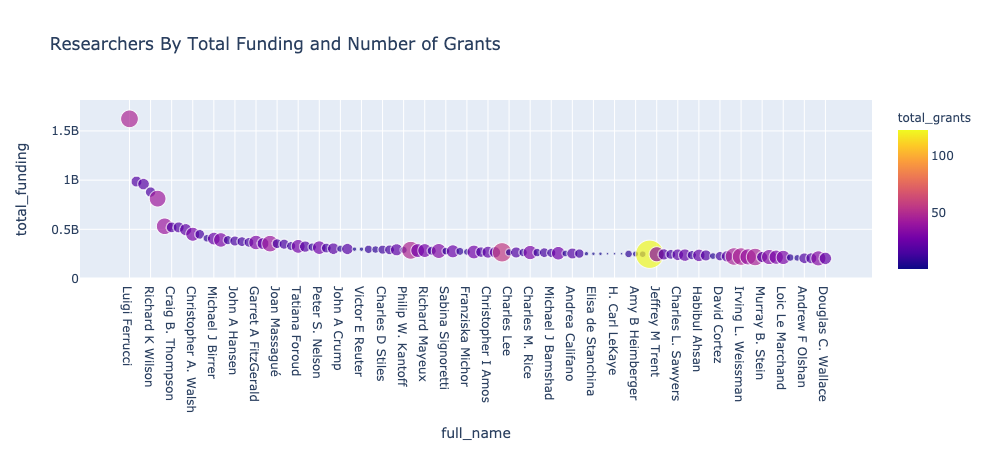

In [17]:
px.scatter(temp1, 
           x="full_name", y="total_funding", 
           hover_name="full_name", 
           size="total_grants", 
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           title="Researchers By Total Funding and Number of Grants")

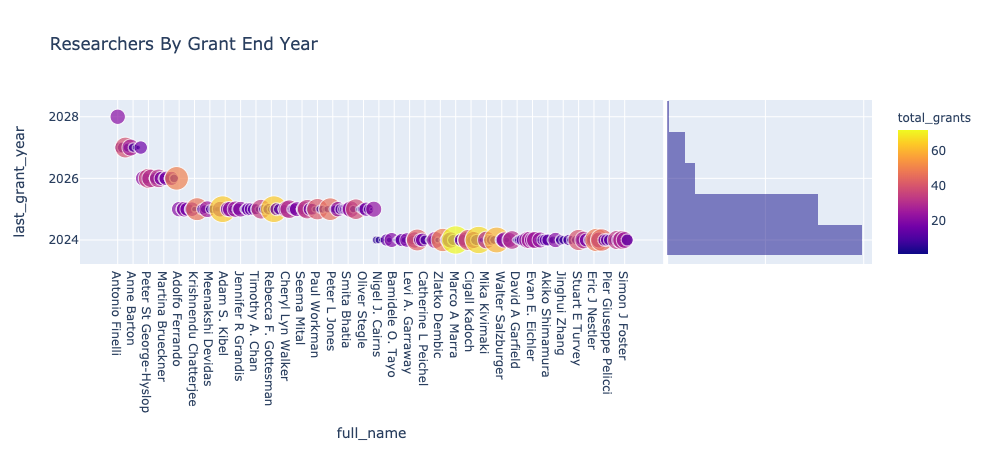

In [18]:
px.scatter(temp2, 
           x="full_name", y="last_grant_year", 
           hover_name="full_name", 
           size="total_grants",
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           marginal_y="histogram",  title="Researchers By Grant End Year")

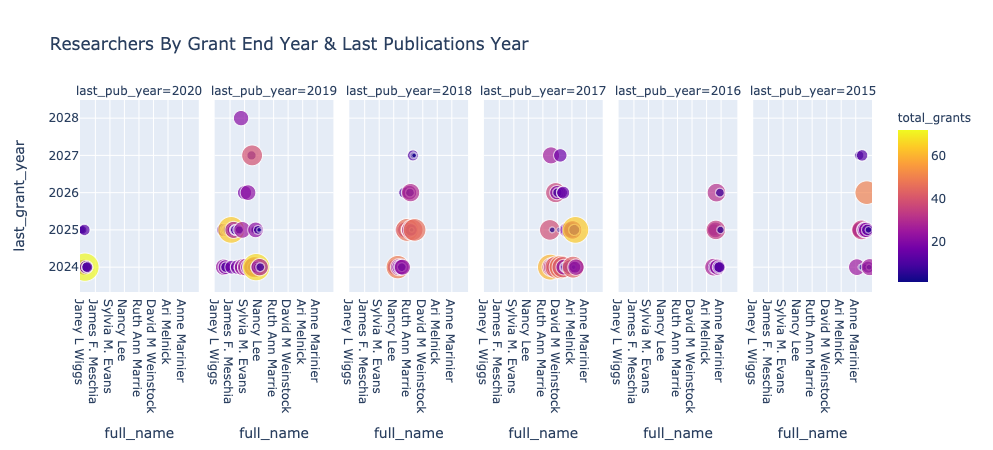

In [19]:
px.scatter(temp2.sort_values("last_pub_year", ascending=False), 
           x="full_name", y="last_grant_year", 
           hover_name="full_name",  
           size="total_grants",
           color="total_grants",
           hover_data=['total_funding', 'total_grants', 'last_grant_year', 'citations_mean', 'altmetric_mean', 'last_pub_year'], 
           facet_col="last_pub_year", 
           title="Researchers By Grant End Year & Last Publications Year")

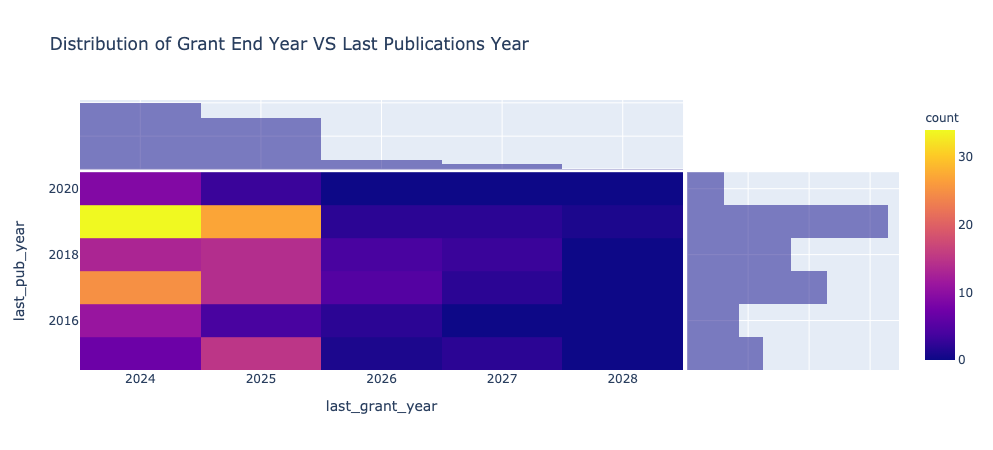

In [20]:
px.density_heatmap(temp2, 
                   x="last_grant_year", y="last_pub_year", 
                   marginal_x="histogram", marginal_y="histogram", 
                   title="Distribution of Grant End Year VS Last Publications Year")